In [1]:
# 2020 Ben Gladders
# Adapted from Deitel.P, Deitel.H (2020) Multi-Classification with the MNIST Dataset.
# In: Intro to Python for Computer Science and Data Science. pp.666-709

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

from datetime import datetime
from PIL import Image
import numpy as np
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pydot

print("TensorFlow version: ", tf.__version__)
# assert version.parse(tf.__version__).release[0] >= 2, \
#    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.1.0


In [3]:
%load_ext tensorboard
# Tensorboard for realtime graphing.

logdir= Path('logs/fit/') / datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 12752), started 18:06:33 ago. (Use '!kill 12752' to kill it.)

In [4]:
%matplotlib inline

image_generator = image.ImageDataGenerator(rescale=1./255, validation_split=0.1)
# rescale normalises data to 0-1(float) range.

In [5]:
BATCH_SIZE = 128
IMG_HEIGHT = 100
IMG_WIDTH = 100
NUM_EPOCHS = 20
train_data_dir = Path('C:/Users/bengl/Pictures/fruits-360/Training')
test_data_dir = Path('C:/Users/bengl/Pictures/fruits-360/Test')
real_data_dir = Path('C:/Users/bengl/Pictures/fruits-360/Real')
# Path() ensures script runs on windows and linux - sorts '/''\'mismatch in OS

In [6]:
train_data_gen = image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(100, 100),
                                                     classes = None,
                                                     class_mode='categorical',
                                                     subset='training')
                                                     # color_mode='grayscale')

Found 54478 images belonging to 120 classes.


In [7]:
valid_data_gen = image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(100, 100),
                                                     classes = None,
                                                     class_mode='categorical',
                                                     subset='validation')
                                                     # color_mode='grayscale')

Found 6020 images belonging to 120 classes.


In [8]:
test_data_gen = image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(100, 100),
                                                     classes = None,
                                                     class_mode='categorical')
                                                     # color_mode='grayscale')

Found 20622 images belonging to 120 classes.


([<matplotlib.patches.Wedge at 0x21b029120f0>,
 [Text(-0.5902819916288199, 0.9869484132206272, 'Train'),
  Text(-0.2952320846036238, -1.1114576088275248, 'Validation'),
  Text(0.8023314650914809, -0.823871482771529, 'Test')],
 [Text(-0.33363764744237645, 0.5578404074725284, '67.2%'),
  Text(-0.16687030868900476, -0.6282151702068617, '7.4%'),
  Text(0.4534916976604022, -0.46566649026216855, '25.4%')])

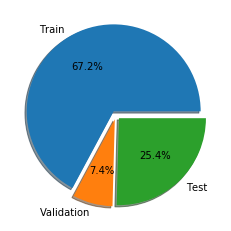

In [9]:
plt.pie([train_data_gen.samples,
         valid_data_gen.samples,
         test_data_gen.samples],
         labels=['Train','Validation', 'Test'],
         explode=(0.05,0.05, 0.05),
         shadow=True,
         autopct='%1.1f%%')

In [10]:
def print_fruit_type(dataset, item_number):
    for item in dataset.class_indices.items():
        if item[1] == dataset.classes[item_number]:
           print('Fruit %d is type: %s' % ( item_number, item[0]))

In [11]:
print_fruit_type(train_data_gen,50500)

Fruit 50500 is type: Tomato 1


In [12]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(np.where(label_batch[n]==1)[0][0])
      plt.axis('off')

In [13]:
image_batch, label_batch = next(train_data_gen)  # load next batch into variables for inspection

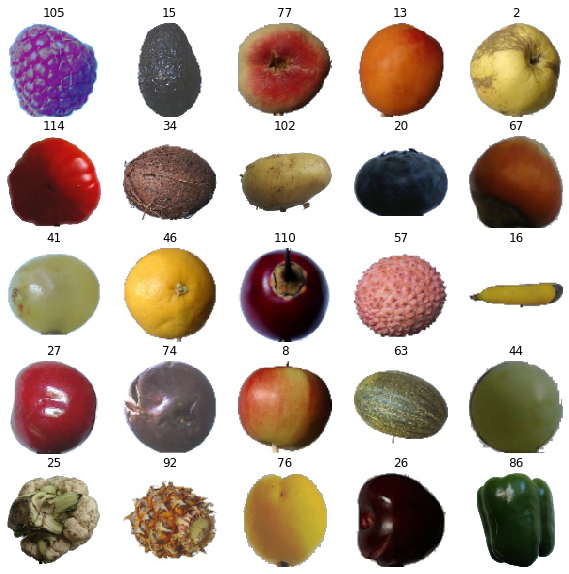

In [14]:
show_batch(image_batch, label_batch)

In [15]:
image_batch.shape # assure data shape is ideal.. 4D tensor [fruit_sample_no, y, x, (r,g, or b)]

(128, 100, 100, 3)

In [16]:
label_batch.shape # [BATCH_SIZE]labels, of 120 fruit options

(128, 120)

In [17]:
image = image_batch[0][50][50][0]  # get red values at pos 50,50
image

0.49803925

In [18]:
label_batch[0]  # display category number for batch_size[fruit_no]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [19]:
np.where(label_batch[0]==1)[0][0] # displays category as int

105

In [20]:
cnn = Sequential()  # Instantiate tensorflow model then add layers

In [21]:
cnn.add(Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu', # rectified linear unit - any neg value will be set 0. Positive values remain unchanged.
               input_shape=(100, 100, 3)))

In [22]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

In [23]:
cnn.add(Conv2D(filters=128,
               kernel_size=(5, 5),
               activation='relu'))

In [24]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

In [25]:
cnn.add(Flatten())

In [26]:
cnn.add(Dense(units=128,
              activation='relu'))  # dense layers have all previous nodes connected to each node in the layer

In [27]:
cnn.add(Dense(units=120,
              activation='softmax'))

In [28]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 61952)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7929984   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               1

In [29]:
#plot_model(cnn, to_file='convnet.png') # cannot get graphviz to work.
#installed stand alone version for windows.
#edited pydot python file path to gvedit.exe
#InvocationException: Program terminated with status: 3221225477. stderr follows: Qt: Untested Windows version 6.2 detected!
#D:\Anaconda\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz\gvedit.exe: illegal option -- 'T'
#D:\Anaconda\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz\gvedit.exe : option -T unrecognized - ignored
#D:\Anaconda\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz\gvedit.exe: illegal option -- 'p'
#D:\Anaconda\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz\gvedit.exe : option -p unrecognized - ignored
#Image(filename='convnet.png')  # display resulting image in notebook

In [30]:
cnn.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [31]:
STEPS_PER_EPOCH = np.ceil(train_data_gen.samples/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.ceil(valid_data_gen.samples/BATCH_SIZE)
TEST_STEPS_PER_EPOCH = np.ceil(test_data_gen.samples/BATCH_SIZE)
print('Batch size: %d' %BATCH_SIZE)
print('Steps per Epoch: %d' %STEPS_PER_EPOCH)
print('Test Steps per Epoch: %d' %TEST_STEPS_PER_EPOCH)
# auto calculation of steps per epoch, requiring only batch size and no_epochs to be set. Avoids data depletion.

Batch size: 128
Steps per Epoch: 426
Test Steps per Epoch: 162


In [32]:
cnn.fit(train_data_gen, steps_per_epoch=STEPS_PER_EPOCH, epochs=NUM_EPOCHS, validation_data=valid_data_gen, validation_steps=VAL_STEPS_PER_EPOCH, verbose=1, callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 426.0 steps, validate for 48.0 steps
Epoch 1/20
426/426 [==============================] - 68s 161ms/step - loss: 0.6113 - accuracy: 0.8577 - val_loss: 0.1364 - val_accuracy: 0.9631
Epoch 2/20
426/426 [==============================] - 43s 102ms/step - loss: 0.0357 - accuracy: 0.9898 - val_loss: 0.2047 - val_accuracy: 0.9377
Epoch 3/20
426/426 [==============================] - 44s 104ms/step - loss: 0.0340 - accuracy: 0.9911 - val_loss: 0.1818 - val_accuracy: 0.9550
Epoch 4/20
426/426 [==============================] - 45s 105ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.1117 - val_accuracy: 0.9733
Epoch 5/20
426/426 [==============================] - 46s 108ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.2231 - val_accuracy: 0.9415
Epoch 6/20
426/426 [==============================] - 45s 107ms/step - loss: 0.0246 - accuracy: 0.9937 - val_loss: 0.1005 - val_accuracy: 0.9764
Epoch 7/20
426/426 [=============

In [33]:
loss, accuracy = cnn.evaluate(test_data_gen,
                              steps=TEST_STEPS_PER_EPOCH,
                              verbose =1)

  ...
    to  
  ['...']
162/162 [==============================] - 20s 122ms/step - loss: 0.1397 - accuracy: 0.9752


In [34]:
print('Loss = %s' %loss)
print('Accuracy = %s' %accuracy)

Loss = 0.13968544948075748
Accuracy = 0.9752206


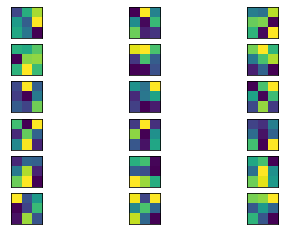

In [35]:
# Seif.G (2019) Available from 
# https://towardsdatascience.com/visualising-filters-and-feature-maps-for-deep-learning-d814e13bd671
# Show weights
layer_dict = dict([(layer.name, layer) for layer in cnn.layers])

layer_name = 'conv2d'
filter_index = 0 # Which filter in this block would you like to visualise?

# Grab the filters and biases for that layer
filters, biases = layer_dict[layer_name].get_weights()

# Normalize filter values to a range of 0 to 1 so we can visualize them
f_min, f_max = np.amin(filters), np.amax(filters)
filters = (filters - f_min) / (f_max - f_min)

# Plot first few filters
n_filters, index = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    
    # Plot each channel separately
    for j in range(3):

        ax = plt.subplot(n_filters, 3, index)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(f[:, :, j], cmap='viridis')
        index += 1
        
plt.show()

In [37]:
real_data_gen = image_generator.flow_from_directory(directory=str(real_data_dir),
                                                     batch_size=7,
                                                     shuffle=True,
                                                     target_size=(100, 100),
                                                     classes = None,
                                                     class_mode='categorical')

Found 7 images belonging to 120 classes.


In [38]:
image, label = next(real_data_gen)  # test on pictures of fruit from home

In [39]:
label  # see which fruit each prediction actually belongs to

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [40]:
predictions = cnn.predict(real_data_gen)

In [41]:
for i in range(7):
    print_fruit_type(real_data_gen,i)

Fruit 0 is type: Avocado ripe
Fruit 1 is type: Lemon
Fruit 2 is type: Limes
Fruit 3 is type: Limes
Fruit 4 is type: Orange
Fruit 5 is type: Tomato 4
Fruit 6 is type: Tomato 4


In [42]:
count =0
for item in predictions:
    print('Photo %d predicted as %d, actual was %d' % (count, np.argmax(item), np.argmax(label[count])))
    count+=1

Photo 0 predicted as 83, actual was 115
Photo 1 predicted as 86, actual was 56
Photo 2 predicted as 86, actual was 56
Photo 3 predicted as 88, actual was 72
Photo 4 predicted as 20, actual was 15
Photo 5 predicted as 87, actual was 115
Photo 6 predicted as 24, actual was 54


In [43]:
# Despite training, validation and evaluation accuracy bieng 97%+, as seen from the cell above,
# this model cannot tell a single fruit from our home taken photos. See Assignment v2 for remedy.

In [44]:
cnn.save('current.h5')  # save machine learning state